<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/titanic_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/LeoFernanndes/functions

Cloning into 'functions'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 48 (delta 25), reused 32 (delta 12), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [0]:
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


url_train = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_%20train.csv'
url_test = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_test.csv'
url_dataframe_feature_engineering = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_feature_engineering.csv'

columns_order = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

train = pd.read_csv(url_train).reindex(columns_order, axis= 1)
test = pd.read_csv(url_test).reindex(columns_order.remove('Survived'), axis= 1)

dataframe = train.append(test, sort= False).set_index(np.arange(0,1309), columns_order)
backup = dataframe.copy()
dataframe = pd.read_csv(url_dataframe_feature_engineering)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


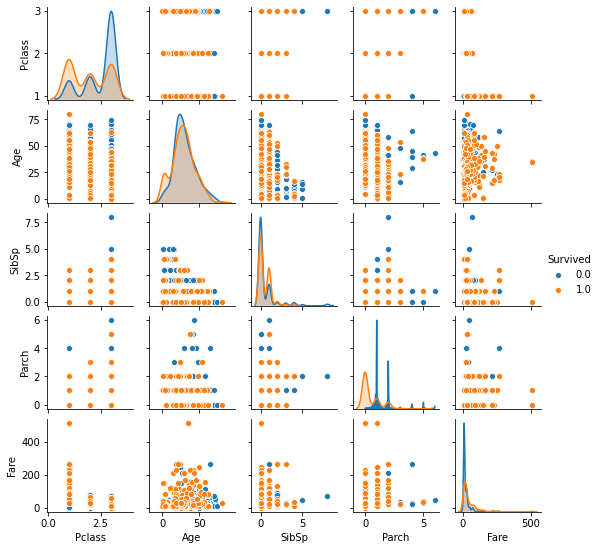

In [3]:
colunas_pair = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

data = backup[colunas_pair]


import seaborn as sns      
sns.pairplot(data, hue='Survived', size=1.5)

Accuracy: 0.8638743455497382, f1_score: 0.8194444444444445
Accuracy: 0.8691099476439791, f1_score: 0.8251748251748252
Accuracy: 0.8691099476439791, f1_score: 0.8251748251748252
Accuracy: 0.8743455497382199, f1_score: 0.8333333333333333
Accuracy: 0.8691099476439791, f1_score: 0.822695035460993
Accuracy: 0.8691099476439791, f1_score: 0.822695035460993


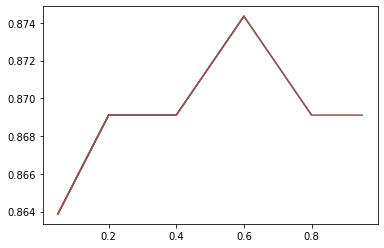

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


dataframe_stack = dataframe.copy()
dataframe_stack_train = dataframe_stack.iloc[0:700]
dataframe_stack_test = dataframe_stack.iloc[700: 891]
dataframe_stack_submit = dataframe_stack.iloc[891:]

'''

colunas = ['Sex', 'Ticket', 'Age', 'Fare', 'Name', 'PassengerId', 'Title',
       'Title_n', 'Cabin', 'Pclass', 'Fare_', 'Pclass_', 'Family',
       'Family_', 'Age_', 'SibSp', 'Embarked', 'Parch', 'Survived']
'''


colunas = ['Fare_', 'Age_', 'Title_n', 'Pclass_', 'Family_', 'Cabin', 'Survived']


df_stack_train = pd.DataFrame({'PassengerId': dataframe_stack_train['PassengerId']}).set_index(['PassengerId'])
df_stack_test = pd.DataFrame({'PassengerId': dataframe_stack_test['PassengerId']}).set_index(['PassengerId'])
df_stack_submit = pd.DataFrame({'PassengerId': dataframe_stack_submit['PassengerId']}).set_index(['PassengerId'])


classifiers = [AdaBoostClassifier(n_estimators=500),
               ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='gini',max_depth=5),
               XGBClassifier(n_estimators=500, nthread=-1, max_depth = 5, seed=1729),
               GradientBoostingClassifier(n_estimators=500),
               DecisionTreeClassifier(),
               AdaBoostClassifier(n_estimators=250),
               ExtraTreesClassifier(n_estimators=250, n_jobs=-1, criterion='gini',max_depth=5),
               XGBClassifier(n_estimators=250, nthread=-1, max_depth = 5, seed=1729),
               GradientBoostingClassifier(n_estimators=250),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               RandomForestClassifier(n_estimators= 100),
               RandomForestClassifier(n_estimators= 300)]


cv_splits = [0.05, 0.2, 0.4, 0.6, 0.8, 0.95]
x_axis = []
y_axis = []


for split in cv_splits:

  iterations = 10


  # training stage 
  for clf in classifiers:
    for n in range(iterations):  


      x_train, x_test, y_train, y_test = train_test_split(dataframe_stack_train[colunas[:-1]], dataframe_stack_train[colunas[-1]], test_size= split, random_state= None)


      clf.fit(x_train, y_train)

      
      clf_ = clf.predict(dataframe_stack_test[colunas[:-1]])
      clf_dataframe_ = pd.DataFrame({n: clf_}, index= df_stack_test.index)
      df_stack_test = pd.concat([df_stack_test, clf_dataframe_], axis= 1)


  mean = df_stack_test.mean(axis= 1)
  mode = df_stack_test.mode(axis= 1)


  f1_score_ = f1_score(mode[0], dataframe_stack_test['Survived'])
  accuracy_score_ = accuracy_score(mode[0], dataframe_stack_test['Survived'])

  x_axis.append(split)
  y_axis.append(accuracy_score_)

  # submission classification stage
  for clf in classifiers:
    for n in range(iterations):  


      x_train, x_test, y_train, y_test = train_test_split(dataframe_stack_train[colunas[:-1]], dataframe_stack_train[colunas[-1]], test_size= 0.6, random_state= None)


      clf.fit(x_train, y_train)

      
      clf_ = clf.predict(dataframe_stack_submit[colunas[:-1]])
      clf_dataframe_ = pd.DataFrame({n: clf_}, index= df_stack_submit.index)
      df_stack_submit = pd.concat([df_stack_submit, clf_dataframe_], axis= 1)


  mean_submission = df_stack_submit.mean(axis= 1)
  mode_submission = df_stack_submit.mode(axis= 1)[0]


  submission = list(mode_submission.map({0.0: 0, 1.0: 1}))
  envio = pd.DataFrame({'PassengerId': dataframe_stack_submit['PassengerId'],
                        'Survived': submission}).set_index(['PassengerId'])

  from google.colab import files


  envio.to_csv('titanic_submission_5.csv')

  print('Accuracy: {}, f1_score: {}'.format(accuracy_score_, f1_score_))

  plt.plot(x_axis, y_axis)

## References

Como selecionar as melhores features para seu modelo de Machine Learning

https://paulovasconcellos.com.br/como-selecionar-as-melhores-features-para-seu-modelo-de-machine-learning-2e9df83d062a

Binary classification - methods comparison

https://www.kaggle.com/klaudiajankowska/binary-classification-methods-comparison

7 types of classification algorithms

https://analyticsindiamag.com/7-types-classification-algorithms/

Classification Metrics

https://turi.com/learn/userguide/evaluation/classification.html#log_loss

Winning ensemble classifier

https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335